# Setup

In [1]:
import sys
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    %tensorflow_version 2.x
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    !pip install -q -U tf-agents-nightly pyvirtualdisplay gym[atari]
    IS_COLAB = True
except Exception:
    IS_COLAB = False

import tensorflow as tf
from tensorflow import keras
import gym
assert tf.__version__ >= "2.0"

import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

PROJECT_ROOT_DIR = "."
FOLDER = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", FOLDER)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

TensorFlow 2.x selected.
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Get:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Packages [25.5 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [75.1 kB]
Hit:12 http://arc

In [2]:
# To fix display issues
! apt-get install x11-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-cufft-10-1 cuda-cufft-dev-10-1 cuda-curand-10-1 cuda-curand-dev-10-1
  cuda-cusolver-10-1 cuda-cusolver-dev-10-1 cuda-cusparse-10-1
  cuda-cusparse-dev-10-1 cuda-license-10-2 cuda-npp-10-1 cuda-npp-dev-10-1
  cuda-nsight-10-1 cuda-nsight-compute-10-1 cuda-nsight-systems-10-1
  cuda-nvgraph-10-1 cuda-nvgraph-dev-10-1 cuda-nvjpeg-10-1
  cuda-nvjpeg-dev-10-1 cuda-nvrtc-10-1 cuda-nvrtc-dev-10-1 cuda-nvvp-10-1
  libcublas10 libnvidia-common-430 nsight-compute-2019.5.0
  nsight-systems-2019.5.2
Use 'apt autoremove' to remove them.
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  x11-utils
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 196 kB of archives.
After this operation, 650 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com

In [0]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass

# Policy Gradients

In [0]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

In [0]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [0]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [6]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22, -40, -50])

In [7]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [0]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

In [0]:
optimizer = keras.optimizers.Adam(lr=0.01)
loss_fn = keras.losses.binary_crossentropy

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [13]:
env = gym.make("CartPole-v1")
env.seed(42);

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))                     
    print("\rIteration: {}, mean rewards: {:.1f}".format(          
        iteration, total_rewards / n_episodes_per_update), end="") 
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Iteration: 149, mean rewards: 178.3

In [0]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

In [0]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim


In [0]:
frames = render_policy_net(model)
plot_animation(frames)

# DQN using tf-agents

## TF-Agents Environments

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

In [0]:
from tf_agents.environments import suite_gym
env = suite_gym.load("Breakout-v4")
env

In [0]:
env.gym

In [0]:
env.seed(42)
env.reset()

TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

In [0]:
env.step(1) # Fire

TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

Saving figure breakout_plot


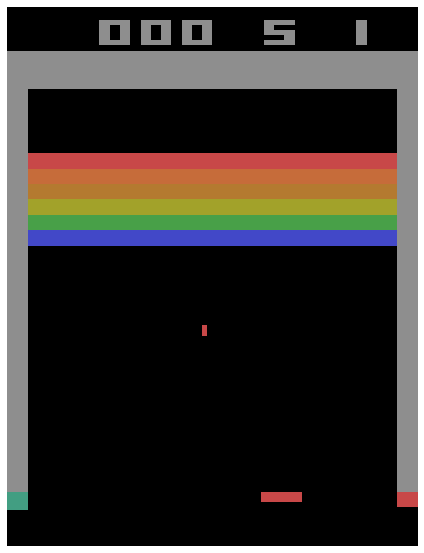

In [0]:
img = env.render(mode="rgb_array")

plt.figure(figsize=(6, 8))
plt.imshow(img)
plt.axis("off")
save_fig("breakout_plot")
plt.show()

In [0]:
env.current_time_step()

TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

## Environment Specifications

In [0]:
env.observation_spec()

BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)

In [0]:
env.action_spec()

BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)

In [0]:
env.time_step_spec()

TimeStep(step_type=ArraySpec(shape=(), dtype=dtype('int32'), name='step_type'), reward=ArraySpec(shape=(), dtype=dtype('float32'), name='reward'), discount=BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0), observation=BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255))

## Environment Wrappers

You can wrap a TF-Agents environments in a TF-Agents wrapper:

In [0]:
from tf_agents.environments.wrappers import ActionRepeat
repeating_env = ActionRepeat(env, times=4)
repeating_env

In [0]:
repeating_env.unwrapped

In [0]:
from functools import partial
from gym.wrappers import TimeLimit

limited_repeating_env = suite_gym.load(
    "Breakout-v4",
    gym_env_wrappers=[partial(TimeLimit, max_episode_steps=10000)],
    env_wrappers=[partial(ActionRepeat, times=4)],
)

In [0]:
limited_repeating_env

In [0]:
limited_repeating_env.unwrapped

In [0]:
from tf_agents.environments import suite_atari
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

max_episode_steps = 27000 
environment_name = "BreakoutNoFrameskip-v4"

env = suite_atari.load(
    environment_name,
    max_episode_steps=max_episode_steps,
    gym_env_wrappers=[AtariPreprocessing, FrameStack4])

In [0]:
env

In [0]:
env.seed(42)
env.reset()
time_step = env.step(1) 
for _ in range(4):
    time_step = env.step(3) 

In [0]:
def plot_observation(obs):
    obs = obs.astype(np.float32)
    img = obs[..., :3]
    current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis=-1), 0.)
    img[..., 0] += current_frame_delta
    img[..., 2] += current_frame_delta
    img = np.clip(img / 150, 0, 1)
    plt.imshow(img)
    plt.axis("off")

Saving figure preprocessed_breakout_plot


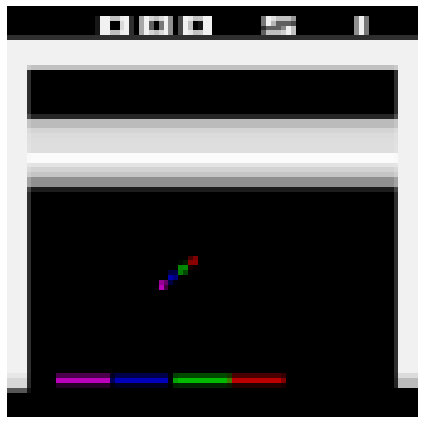

In [0]:
plt.figure(figsize=(6, 6))
plot_observation(time_step.observation)
save_fig("preprocessed_breakout_plot")
plt.show()

In [0]:
from tf_agents.environments.tf_py_environment import TFPyEnvironment

tf_env = TFPyEnvironment(env)

## Creating the DQN

In [0]:
from tf_agents.networks.q_network import QNetwork

preprocessing_layer = keras.layers.Lambda(
                          lambda obs: tf.cast(obs, np.float32) / 255.)
conv_layer_params=[(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_params=[512]

q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params)

In [0]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent

train_step = tf.Variable(0)
update_period = 4 # run a training step every 4 collect steps
optimizer = tf.compat.v1.train.RMSPropOptimizer(learning_rate=2.5e-4, decay=0.95, momentum=0.0,
                                     epsilon=0.00001, centered=True)
epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0, 
    decay_steps=250000 // update_period, 
    end_learning_rate=0.01) 
agent = DqnAgent(tf_env.time_step_spec(),
                 tf_env.action_spec(),
                 q_network=q_net,
                 optimizer=optimizer,
                 target_update_period=2000,
                 td_errors_loss_fn=keras.losses.Huber(reduction="none"),
                 gamma=0.99, 
                 train_step_counter=train_step,
                 epsilon_greedy=lambda: epsilon_fn(train_step))
agent.initialize()

In [0]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer
# from tf_agents.replay_buffers import py_hashed_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
     max_length=100000)

# ,batch_size=tf_env.batch_size
# , max_length=1000000

replay_buffer_observer = replay_buffer.add_batch

In [0]:
class ShowProgress:
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

In [0]:
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]

In [0]:
train_metrics[0].result()

<tf.Tensor: id=470, shape=(), dtype=int64, numpy=0>

In [0]:
from tf_agents.eval.metric_utils import log_metrics
import logging
logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


In [0]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period) # collect 4 steps for each training iteration

In [0]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(),
                                        tf_env.action_spec())
init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(20000)],
    num_steps=20000) # <=> 80,000 ALE frames
final_time_step, final_policy_state = init_driver.run()

20000/20000

In [0]:
dataset = replay_buffer.as_dataset(
    sample_batch_size=64,
    num_steps=2,
    num_parallel_calls=3).prefetch(3)

In [0]:
from tf_agents.utils.common import function

collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

In [0]:
def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        print("\r{} loss:{:.5f}".format(
            iteration, train_loss.loss.numpy()), end="")
        if iteration % 1000 == 0:
            log_metrics(train_metrics)

In [0]:
train_agent(n_iterations=10000)

INFO:absl: 
		 NumberOfEpisodes = 660
		 EnvironmentSteps = 120004
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 193.1999969482422


998 loss:0.00012

INFO:absl: 
		 NumberOfEpisodes = 680
		 EnvironmentSteps = 124004
		 AverageReturn = 1.600000023841858
		 AverageEpisodeLength = 213.3000030517578


1997 loss:0.00127

INFO:absl: 
		 NumberOfEpisodes = 699
		 EnvironmentSteps = 128004
		 AverageReturn = 1.600000023841858
		 AverageEpisodeLength = 204.10000610351562


2999 loss:0.00082

INFO:absl: 
		 NumberOfEpisodes = 719
		 EnvironmentSteps = 132004
		 AverageReturn = 1.5
		 AverageEpisodeLength = 204.3000030517578


3998 loss:0.00209

INFO:absl: 
		 NumberOfEpisodes = 740
		 EnvironmentSteps = 136004
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 185.10000610351562


4997 loss:0.01098

INFO:absl: 
		 NumberOfEpisodes = 760
		 EnvironmentSteps = 140004
		 AverageReturn = 1.399999976158142
		 AverageEpisodeLength = 190.5


5999 loss:0.00299

INFO:absl: 
		 NumberOfEpisodes = 779
		 EnvironmentSteps = 144004
		 AverageReturn = 1.899999976158142
		 AverageEpisodeLength = 221.3000030517578


6998 loss:0.00027

INFO:absl: 
		 NumberOfEpisodes = 800
		 EnvironmentSteps = 148004
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 201.89999389648438


7997 loss:0.00103

INFO:absl: 
		 NumberOfEpisodes = 819
		 EnvironmentSteps = 152004
		 AverageReturn = 1.899999976158142
		 AverageEpisodeLength = 218.6999969482422


8999 loss:0.00076

INFO:absl: 
		 NumberOfEpisodes = 840
		 EnvironmentSteps = 156004
		 AverageReturn = 1.0
		 AverageEpisodeLength = 200.39999389648438


9999 loss:0.00731

In [0]:
frames = []
def save_frames(trajectory):
    global frames
    frames.append(tf_env.pyenv.envs[0].render(mode="rgb_array"))

prev_lives = tf_env.pyenv.envs[0].ale.lives()
def reset_and_fire_on_life_lost(trajectory):
    global prev_lives
    lives = tf_env.pyenv.envs[0].ale.lives()
    if prev_lives != lives:
        tf_env.reset()
        tf_env.pyenv.envs[0].step(1)
        prev_lives = lives

watch_driver = DynamicStepDriver(
    tf_env,
    agent.policy,
    observers=[save_frames, reset_and_fire_on_life_lost, ShowProgress(1000)],
    num_steps=1000)
final_time_step, final_policy_state = watch_driver.run()

plot_animation(frames)

900/1000

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


1000/1000

In [0]:
import PIL

image_path = os.path.join("images", "rl", "breakout.gif")
frame_images = [PIL.Image.fromarray(frame) for frame in frames[:150]]
frame_images[0].save(image_path, format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=30,
                     loop=0)

In [0]:
%%html
<img src="images/rl/breakout.gif" />